## 1. basic I/O with python


In [1]:
# 1. pickle object 
# object ==> serialization ==> binary
# binary ==> deserialization ==> object 

from pylab import plt,mpl
plt.style.use('seaborn')
mpl.rcParams['font.family']= 'serif'
%matplotlib inline 

import pickle
import os
import time
import numpy as np 
from random import gauss 


In [3]:
a = [gauss(1.5,2) for i in range(1000000)]
path = os.getcwd()
pkl_file=open(path+'/data.pkl','wb')

%time pickle.dump(a,pkl_file)
pkl_file.close()

CPU times: user 18.4 ms, sys: 10.7 ms, total: 29.1 ms
Wall time: 34.5 ms


In [4]:
pkl_file = open(path+'/data.pkl','rb')
%time b=pickle.load(pkl_file)
pkl_file.close()

CPU times: user 45.1 ms, sys: 19.6 ms, total: 64.7 ms
Wall time: 67.5 ms


In [5]:
np.allclose(np.array(a),np.array(b))

True

pickle stores objects according to FIFO, so it is problematic for metainformation to user beforehand what is stored in a pickle file. The solution is the follwoing:
use the __dict__ object to store

In [6]:
pkl_file = open(path + '/data.pkl','wb')
pickle.dump({'a':a,'b':b},pkl_file)
pkl_file.close()

pkl_file = open(path + '/data.pkl','rb')
data = pickle.load(pkl_file)
pkl_file.close()

for key in data.keys():
    print(key,data[key][:4])

a [2.6569403640744547, 2.238416786770553, 3.362625428469582, 0.1168719360713304]
b [2.6569403640744547, 2.238416786770553, 3.362625428469582, 0.1168719360713304]


## 2. reading /writing txt into csv 


In [7]:
import pandas as pd 
t0=time.time()
rows = 5000
a = np.random.standard_normal((rows,5)).round(4)
t = pd.date_range(start='2021/1/1',periods=rows,freq='H')
csv_file = open(path+'/data.csv','w')
header = 'date,no1,no2,no3,no4,no5\n'
csv_file.write(header)
for t_,(no1,no2,no3,no4,no5) in zip(t,a):
    s = '{},{},{},{},{},{}\n'.format(t_,no1,no2,no3,no4,no5)
    csv_file.write(s)
csv_file.close()
t1=time.time()
print('Using {0:.4f} s'.format(t1-t0))

Using 0.0398 s


## 3. working with a database 


In [23]:
import sqlite3 as sq3
con = sq3.connect(path+'/numbs.db')
query = 'CREATE TABLE numbs (Date date,No1 real, No2 real)'
con.execute(query)
con.commit()

In [24]:
q = con.execute
q('SELECT * from sqlite_master').fetchall()

[('table',
  'numbs',
  'numbs',
  2,
  'CREATE TABLE numbs (Date date,No1 real, No2 real)')]

In [28]:
import datetime

now = datetime.datetime.now()
q('INSERT INTO numbs VALUES(?,?,?)',(now,0.12,0.73))


In [29]:
np.random.seed(100)
data=np.random.standard_normal((rows,2)).round(4)

TypeError: 'list' object cannot be interpreted as an integer

In [30]:
%%time  
# this magic function has to be in the first line of cells 
for row in data:
    now = datetime.datetime.now()
    q('INSERT INTO numbs VALUES(?,?,?)',(now,row[0],row[1]))
con.commit()

CPU times: user 63 ms, sys: 4.1 ms, total: 67.1 ms
Wall time: 64.2 ms


In [31]:
q('SELECT * FROM numbs').fetchmany(4)

[('2021-06-04 23:46:22.734652', 0.12, 0.73),
 ('2021-06-04 23:46:32.447896', 0.12, 0.73),
 ('2021-06-04 23:46:34.488572', -1.7498, 0.3427),
 ('2021-06-04 23:46:34.489206', 1.153, -0.2524)]

In [32]:
q('SELECT * FROM numbs WHERE No1 >2.5').fetchmany(4)

[('2021-06-04 23:46:34.495650', 3.1734, 3.3342),
 ('2021-06-04 23:46:34.496169', 2.7213, -1.9729),
 ('2021-06-04 23:46:34.498647', 3.8579, 3.0756),
 ('2021-06-04 23:46:34.500668', 2.6474, 0.1333)]

In [33]:
pointer = q('SELECT * from numbs')
rows = pointer.fetchall()
rows[:3]

[('2021-06-04 23:46:22.734652', 0.12, 0.73),
 ('2021-06-04 23:46:32.447896', 0.12, 0.73),
 ('2021-06-04 23:46:34.488572', -1.7498, 0.3427)]

In [18]:
# drop table 
q('DROP TABLE if EXISTS numbs')

In [34]:
q('SELECT * FROM sqlite_master').fetchall()

[('table',
  'numbs',
  'numbs',
  2,
  'CREATE TABLE numbs (Date date,No1 real, No2 real)')]

## 4. From sql to pandas 

In [35]:
%time data = pd.read_sql('SELECT * FROM numbs',con)

CPU times: user 23.3 ms, sys: 2.87 ms, total: 26.2 ms
Wall time: 25.4 ms


In [36]:
data.head()

,Date,No1,No2
0,2021-06-04 23:46:22.734652,0.1200,0.7300
1,2021-06-04 23:46:32.447896,0.1200,0.7300
2,2021-06-04 23:46:34.488572,-1.7498,0.3427
3,2021-06-04 23:46:34.489206,1.1530,-0.2524
4,2021-06-04 23:46:34.489351,0.9813,0.5142


In [46]:
%%time
q='(No1>0.5|No1<-0.5)&(No2>1|No2<-1)'
res = data[['No1','No2']].query(q)


CPU times: user 11.9 ms, sys: 1.51 ms, total: 13.4 ms
Wall time: 11.9 ms


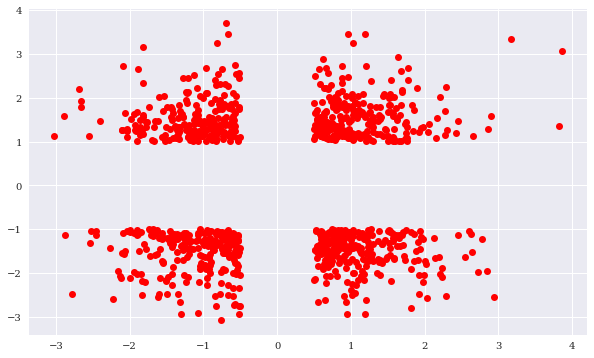

In [48]:
plt.figure(figsize=(10,6))
plt.plot(res['No1'],res['No2'],'ro')